# 02. U-Net Model Training

This notebook is used to train a basic U-Net model. It includes:

- Loading data and configuration  
- Creating the U-Net architecture  
- Training the model  
- Saving the best weights  
- Visualizing the training process

In [7]:
import sys
import os

# Add the project root to the Python path
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

import torch
import torch.nn as nn
import yaml
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Import our modules
from models.unet import UNet, create_unet_model
from engine.trainer import Trainer
from datasets import ChestXrayDataset, create_data_loaders, visualize_sample
from utils.losses import get_loss_function
from utils.metrics import SegmentationMetrics

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

%matplotlib inline


使用设备: cpu


## 1. Load Configuration

In [4]:
# Load U-Net configuration
with open('../configs/unet.yaml', 'r') as f:
     config = yaml.safe_load(f)
    
# Alternative for utf-8 encoded configs
# with open('configs/unet.yaml', 'r', encoding='utf-8') as f:
#     config = yaml.safe_load(f)

print("U-Net Configuration:")
print(f"Model: {config['model']['name']}")
print(f"Input Channels: {config['model']['in_channels']}")
print(f"Output Channels: {config['model']['out_channels']}")
print(f"Feature Layers: {config['model']['features']}")
print(f"Dropout: {config['model']['dropout']}")
print(f"\nTraining Parameters:")
print(f"Batch Size: {config['training']['batch_size']}")
print(f"Learning Rate: {config['training']['learning_rate']}")
print(f"Number of Epochs: {config['training']['num_epochs']}")
print(f"Loss Function: {config['loss']['type']}")


U-Net配置:
模型: unet
输入通道: 1
输出通道: 1
特征层: [64, 128, 256, 512]
Dropout: 0.1

训练参数:
Batch size: 16
学习率: 0.001
训练轮数: 40
损失函数: dice_bce


## 2. Create Dataset and Data Loaders

In [6]:
import yaml
from pathlib import Path

def load_yaml(p):
    with open(p, 'r', encoding='utf-8') as f:
        return yaml.safe_load(f)

def deep_update(base, override):
    for k, v in override.items():
        if isinstance(v, dict) and isinstance(base.get(k), dict):
            deep_update(base[k], v)
        else:
            base[k] = v
    return base

base = load_yaml('/Users/t/Documents/DISSERTATION/configs/default.yaml') 
over = load_yaml('/Users/t/Documents/DISSERTATION/configs/unet.yaml')    
config = deep_update(base, over)

# verify
for k in ('metadata_path','split_path'):
    p = Path(config['data'][k]).expanduser()
    print(k, '->', p, 'exists:', p.exists())


metadata_path -> data/metadata.csv exists: False
split_path -> data/split.csv exists: False


In [7]:
%cd ~/Documents/DISSERTATION

/Users/t/Documents/DISSERTATION


创建数据加载器...
Loaded 246 samples for train split
Loaded 246 samples for val split
Loaded 212 samples for test split
训练集: 246 样本
验证集: 246 样本
测试集: 212 样本
正样本权重: 2.961

训练数据样本:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


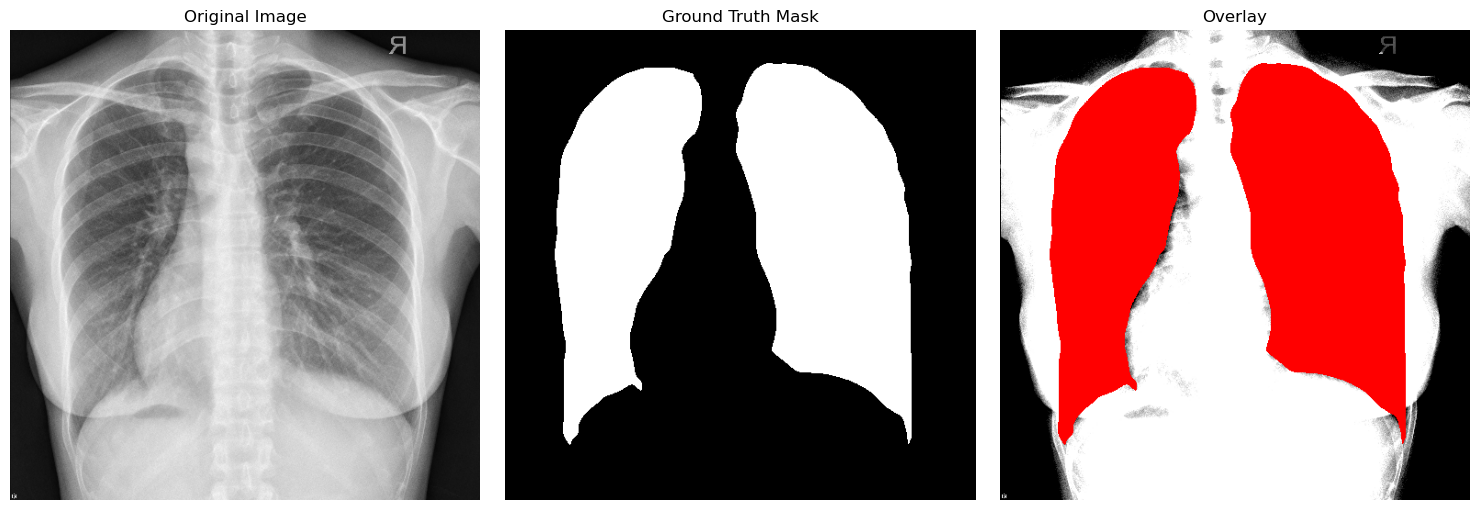

Sample Info:
  Name: 1478
  Size: (2398, 2254)
  Positive Ratio: 0.351


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


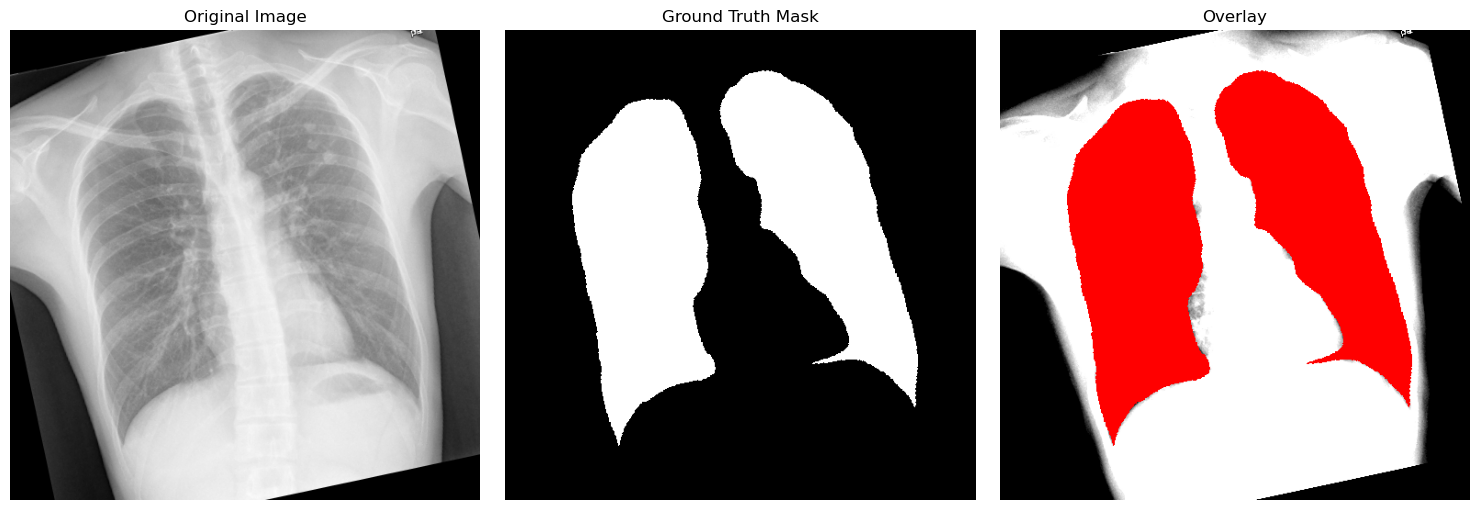

Sample Info:
  Name: 1023
  Size: (3000, 2844)
  Positive Ratio: 0.284


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


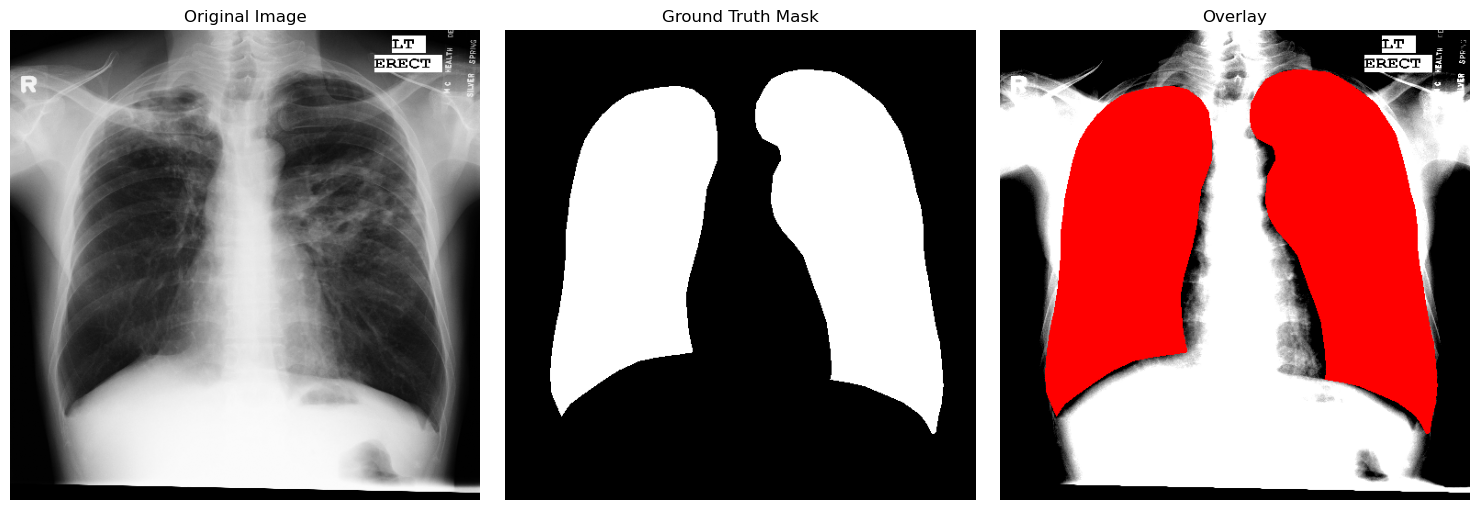

Sample Info:
  Name: 1572
  Size: (4892, 4020)
  Positive Ratio: 0.348


In [8]:
# Create data loaders
train_loader, val_loader, test_loader, pos_weight = create_data_loaders(config)

print(f"Training set: {len(train_loader.dataset)} samples")
print(f"Validation set: {len(val_loader.dataset)} samples")
print(f"Test set: {len(test_loader.dataset)} samples")
print(f"Positive class weight: {pos_weight:.3f}")

# Visualize a few training samples
train_dataset = train_loader.dataset
for i in range(3):
    idx = np.random.randint(0, len(train_dataset))
    sample = visualize_sample(train_dataset, idx)


## 3. Create the U-Net Model

In [10]:
# Create U-Net model
model = create_unet_model(config)
model.to(device)

# Print model summary
model.print_summary(input_size=(1, 512, 512))

# Test model forward pass
model.eval()
with torch.no_grad():
    test_input = torch.randn(2, 1, 512, 512).to(device)
    test_output = model(test_input)
    print(f"Test input shape: {test_input.shape}")
    print(f"Test output shape: {test_output.shape}")
    print(f"Output value range: [{test_output.min():.3f}, {test_output.max():.3f}]")

创建U-Net模型...
Model: U-Net
Input size: (1, 512, 512)
Output size: (1, 512, 512)
------------------------------------------------------------
Total params: 13,394,177
Trainable params: 13,394,177
Non-trainable params: 0
Model size: 51.13 MB

测试模型前向传播...
测试输入shape: torch.Size([2, 1, 512, 512])
测试输出shape: torch.Size([2, 1, 512, 512])
输出范围: [-0.053, 0.010]


## 4. Set Up the Trainer

In [12]:
# Create trainer
trainer = Trainer(model, config, device)

print(f"Optimizer: {type(trainer.optimizer).__name__}")
print(f"Loss function: {type(trainer.criterion).__name__}")
print(f"Learning rate scheduler: {type(trainer.scheduler).__name__ if trainer.scheduler else 'None'}")
print(f"Early stopping patience: {trainer.early_stopping.patience} epochs")

创建训练器...
Loaded 246 samples for train split
Loaded 246 samples for val split
Loaded 212 samples for test split
Training on device: cpu
Dataset sizes - Train: 246, Val: 246, Test: 212
Positive weight: 2.961
训练器设置完成!
优化器: Adam
损失函数: CombinedLoss
学习率调度器: ReduceLROnPlateau
早停耐心: 6 epochs


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 5. Start Training

In [14]:
# Start training
print("Starting U-Net model training...")
print("=" * 60)

# num_epochs = 5  # Quick test
num_epochs = config['training']['num_epochs']

history = trainer.train(num_epochs=num_epochs)

print("\nTraining completed!")


开始训练U-Net模型...
Starting training for 40 epochs...


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Best model saved to checkpoints/unet/best_model.pt
Epoch 1/40 - 1288.60s
  Train - Loss: 0.5417, Dice: 0.6164
  Val   - Loss: 1.7775, Dice: 0.6232, IoU: 0.5176
  LR: 0.001000


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/40 - 1213.87s
  Train - Loss: 0.4096, Dice: 0.7499
  Val   - Loss: 0.6304, Dice: 0.6053, IoU: 0.4914
  LR: 0.001000


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Best model saved to checkpoints/unet/best_model.pt
Epoch 3/40 - 1207.92s
  Train - Loss: 0.3615, Dice: 0.7767
  Val   - Loss: 0.4783, Dice: 0.6766, IoU: 0.5302
  LR: 0.001000


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Best model saved to checkpoints/unet/best_model.pt
Epoch 4/40 - 1212.03s
  Train - Loss: 0.3032, Dice: 0.8140
  Val   - Loss: 0.2597, Dice: 0.8612, IoU: 0.7650
  LR: 0.001000


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/40 - 1209.92s
  Train - Loss: 0.2544, Dice: 0.8512
  Val   - Loss: 0.3552, Dice: 0.7564, IoU: 0.6153
  LR: 0.001000


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/40 - 1211.77s
  Train - Loss: 0.2084, Dice: 0.8783
  Val   - Loss: 0.2862, Dice: 0.8261, IoU: 0.7193
  LR: 0.001000


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/40 - 1209.56s
  Train - Loss: 0.1760, Dice: 0.8959
  Val   - Loss: 0.4196, Dice: 0.6989, IoU: 0.5479
  LR: 0.001000


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Best model saved to checkpoints/unet/best_model.pt
Epoch 8/40 - 1212.11s
  Train - Loss: 0.1712, Dice: 0.8951
  Val   - Loss: 0.1776, Dice: 0.8822, IoU: 0.7933
  LR: 0.001000


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/40 - 1214.51s
  Train - Loss: 0.1460, Dice: 0.9139
  Val   - Loss: 0.2169, Dice: 0.8563, IoU: 0.7523
  LR: 0.001000


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Best model saved to checkpoints/unet/best_model.pt
Epoch 10/40 - 1212.54s
  Train - Loss: 0.1435, Dice: 0.9156
  Val   - Loss: 0.1185, Dice: 0.9279, IoU: 0.8677
  LR: 0.001000
  Detailed Val Metrics:
    Precision: 0.8982
    Recall: 0.9628
    Accuracy: 0.9630


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Best model saved to checkpoints/unet/best_model.pt
Epoch 11/40 - 1211.18s
  Train - Loss: 0.1296, Dice: 0.9243
  Val   - Loss: 0.1050, Dice: 0.9408, IoU: 0.8897
  LR: 0.001000


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12/40 - 1211.67s
  Train - Loss: 0.1238, Dice: 0.9280
  Val   - Loss: 0.1443, Dice: 0.9033, IoU: 0.8258
  LR: 0.001000


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13/40 - 1209.92s
  Train - Loss: 0.1159, Dice: 0.9316
  Val   - Loss: 0.1246, Dice: 0.9362, IoU: 0.8824
  LR: 0.001000


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14/40 - 1211.66s
  Train - Loss: 0.1161, Dice: 0.9294
  Val   - Loss: 0.1048, Dice: 0.9324, IoU: 0.8753
  LR: 0.001000


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Best model saved to checkpoints/unet/best_model.pt
Epoch 15/40 - 1212.18s
  Train - Loss: 0.1023, Dice: 0.9385
  Val   - Loss: 0.0931, Dice: 0.9494, IoU: 0.9056
  LR: 0.001000


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16/40 - 1216.29s
  Train - Loss: 0.1099, Dice: 0.9336
  Val   - Loss: 0.1060, Dice: 0.9463, IoU: 0.9002
  LR: 0.001000


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17/40 - 1219.20s
  Train - Loss: 0.1246, Dice: 0.9243
  Val   - Loss: 0.1003, Dice: 0.9360, IoU: 0.8838
  LR: 0.001000


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18/40 - 1215.89s
  Train - Loss: 0.1090, Dice: 0.9330
  Val   - Loss: 0.1004, Dice: 0.9376, IoU: 0.8848
  LR: 0.001000


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19/40 - 1213.46s
  Train - Loss: 0.1016, Dice: 0.9379
  Val   - Loss: 0.0933, Dice: 0.9421, IoU: 0.8926
  LR: 0.000500


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Best model saved to checkpoints/unet/best_model.pt
Epoch 20/40 - 1213.43s
  Train - Loss: 0.0943, Dice: 0.9440
  Val   - Loss: 0.0840, Dice: 0.9529, IoU: 0.9119
  LR: 0.000500
  Detailed Val Metrics:
    Precision: 0.9493
    Recall: 0.9589
    Accuracy: 0.9766


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Best model saved to checkpoints/unet/best_model.pt
Epoch 21/40 - 1214.68s
  Train - Loss: 0.0892, Dice: 0.9488
  Val   - Loss: 0.0829, Dice: 0.9540, IoU: 0.9138
  LR: 0.000500


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Best model saved to checkpoints/unet/best_model.pt
Epoch 22/40 - 1219.81s
  Train - Loss: 0.0908, Dice: 0.9470
  Val   - Loss: 0.0834, Dice: 0.9540, IoU: 0.9138
  LR: 0.000500


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 23/40 - 1214.23s
  Train - Loss: 0.0891, Dice: 0.9443
  Val   - Loss: 0.0860, Dice: 0.9476, IoU: 0.9021
  LR: 0.000500


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Best model saved to checkpoints/unet/best_model.pt
Epoch 24/40 - 1219.15s
  Train - Loss: 0.0834, Dice: 0.9500
  Val   - Loss: 0.0797, Dice: 0.9564, IoU: 0.9182
  LR: 0.000500


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 25/40 - 1220.17s
  Train - Loss: 0.0881, Dice: 0.9480
  Val   - Loss: 0.0783, Dice: 0.9546, IoU: 0.9146
  LR: 0.000500


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Best model saved to checkpoints/unet/best_model.pt
Epoch 26/40 - 1215.29s
  Train - Loss: 0.0823, Dice: 0.9509
  Val   - Loss: 0.0775, Dice: 0.9575, IoU: 0.9202
  LR: 0.000500


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 27/40 - 1216.73s
  Train - Loss: 0.0802, Dice: 0.9527
  Val   - Loss: 0.0777, Dice: 0.9542, IoU: 0.9140
  LR: 0.000500


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 28/40 - 1219.35s
  Train - Loss: 0.0768, Dice: 0.9547
  Val   - Loss: 0.0781, Dice: 0.9575, IoU: 0.9201
  LR: 0.000500


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 29/40 - 1216.88s
  Train - Loss: 0.0849, Dice: 0.9477
  Val   - Loss: 0.0834, Dice: 0.9552, IoU: 0.9160
  LR: 0.000500


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Early stopping triggered at epoch 29
Training completed! Best validation Dice: 0.9575

训练完成!


## 6. 可视化训练过程

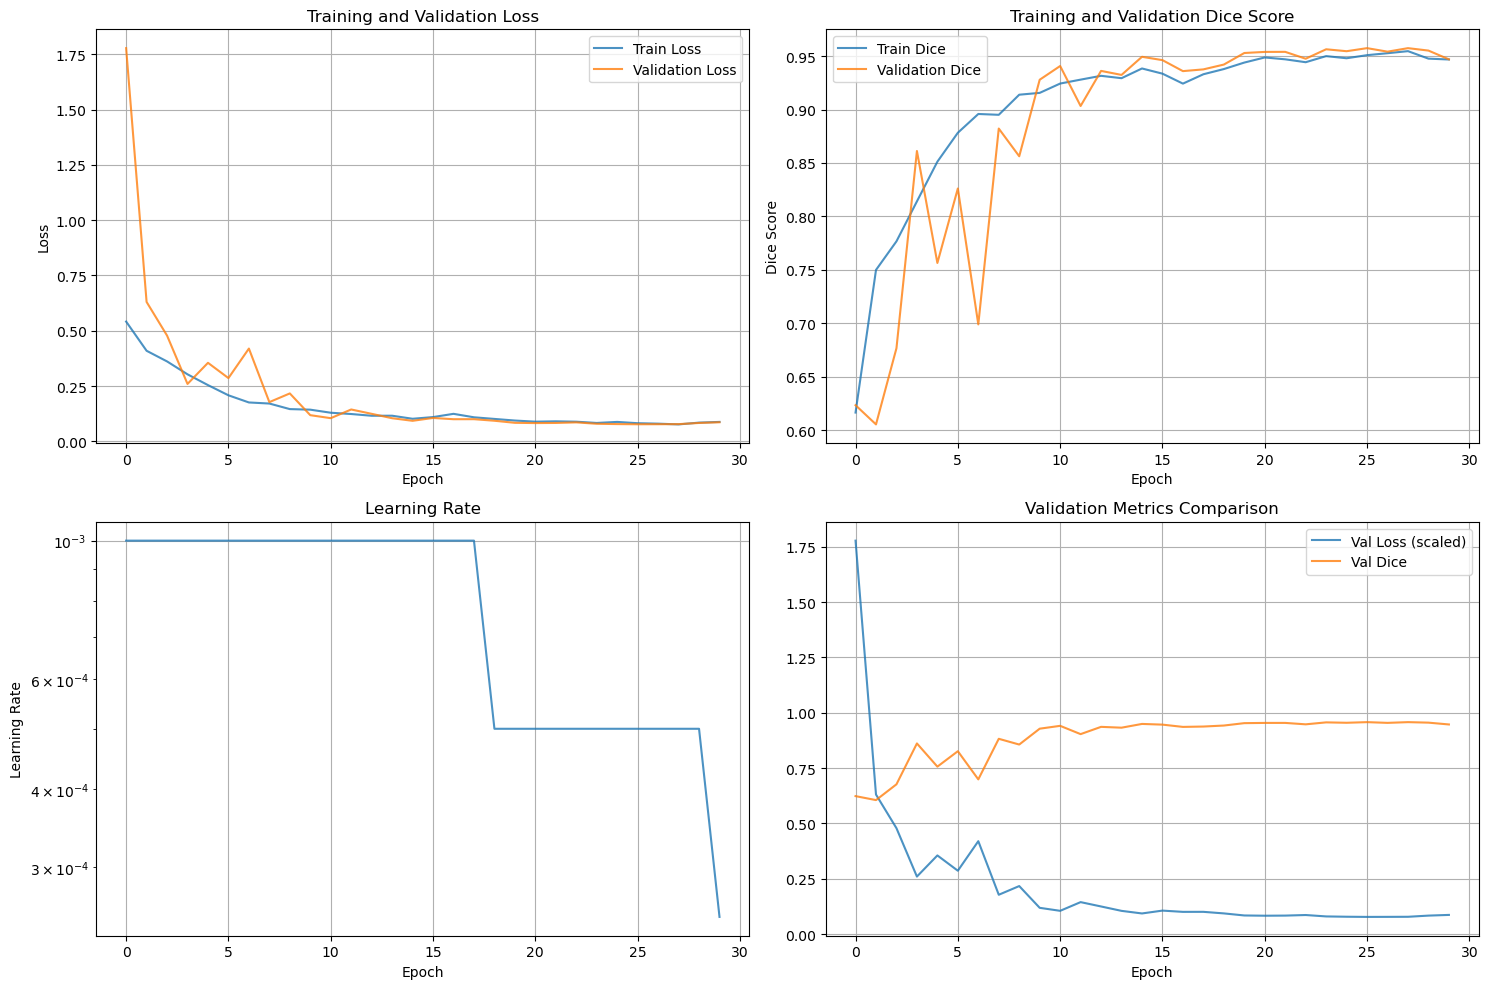

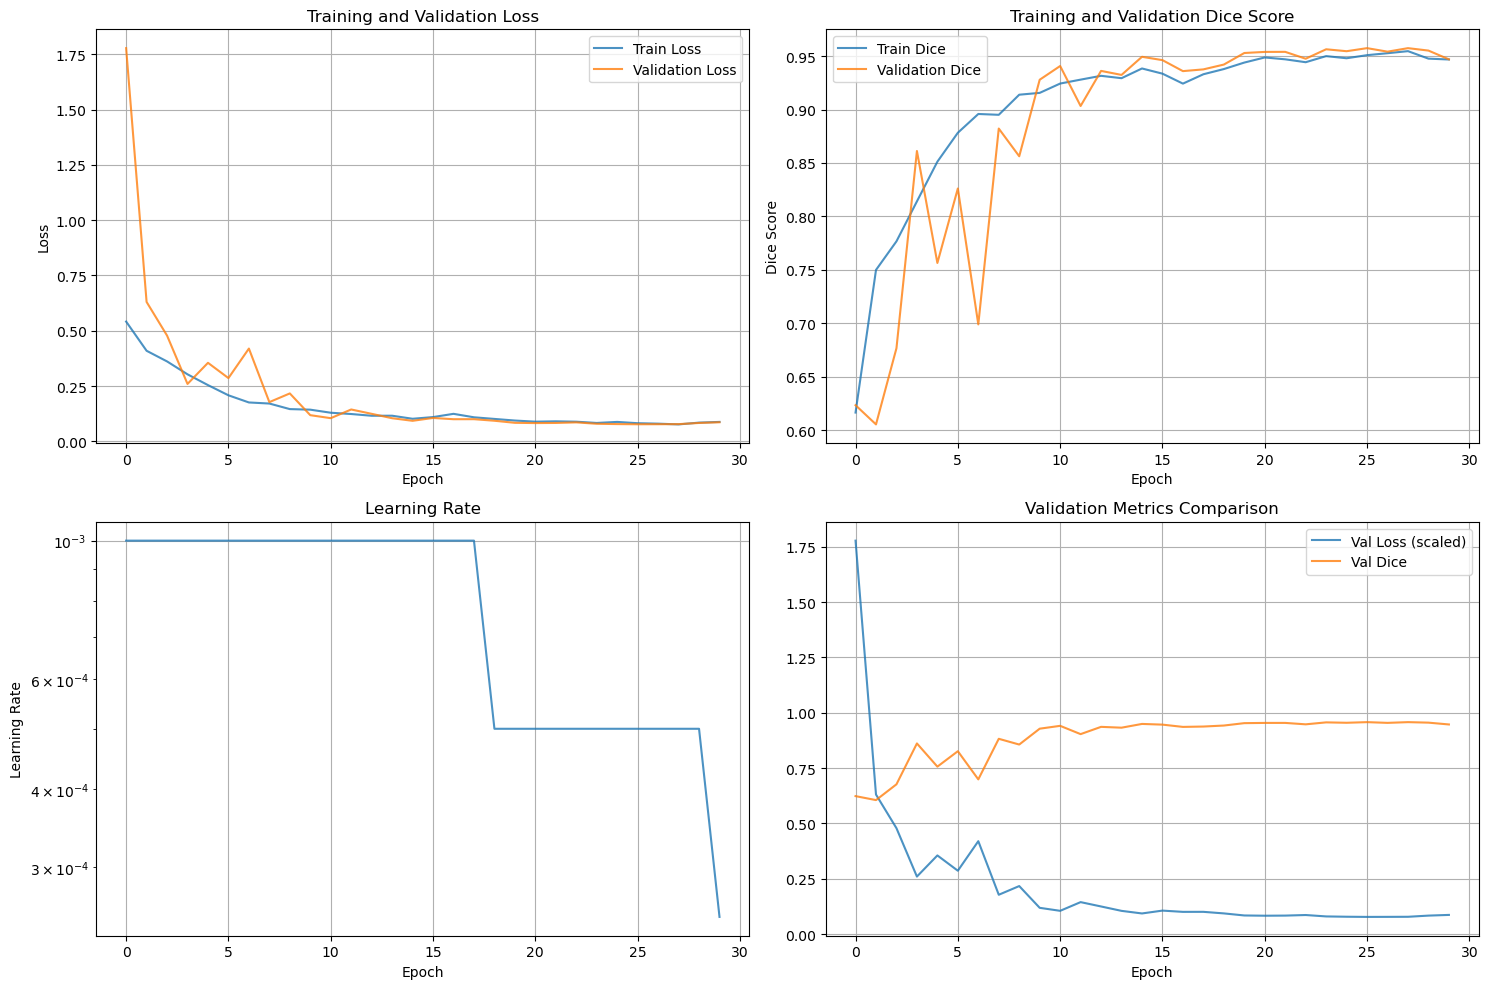

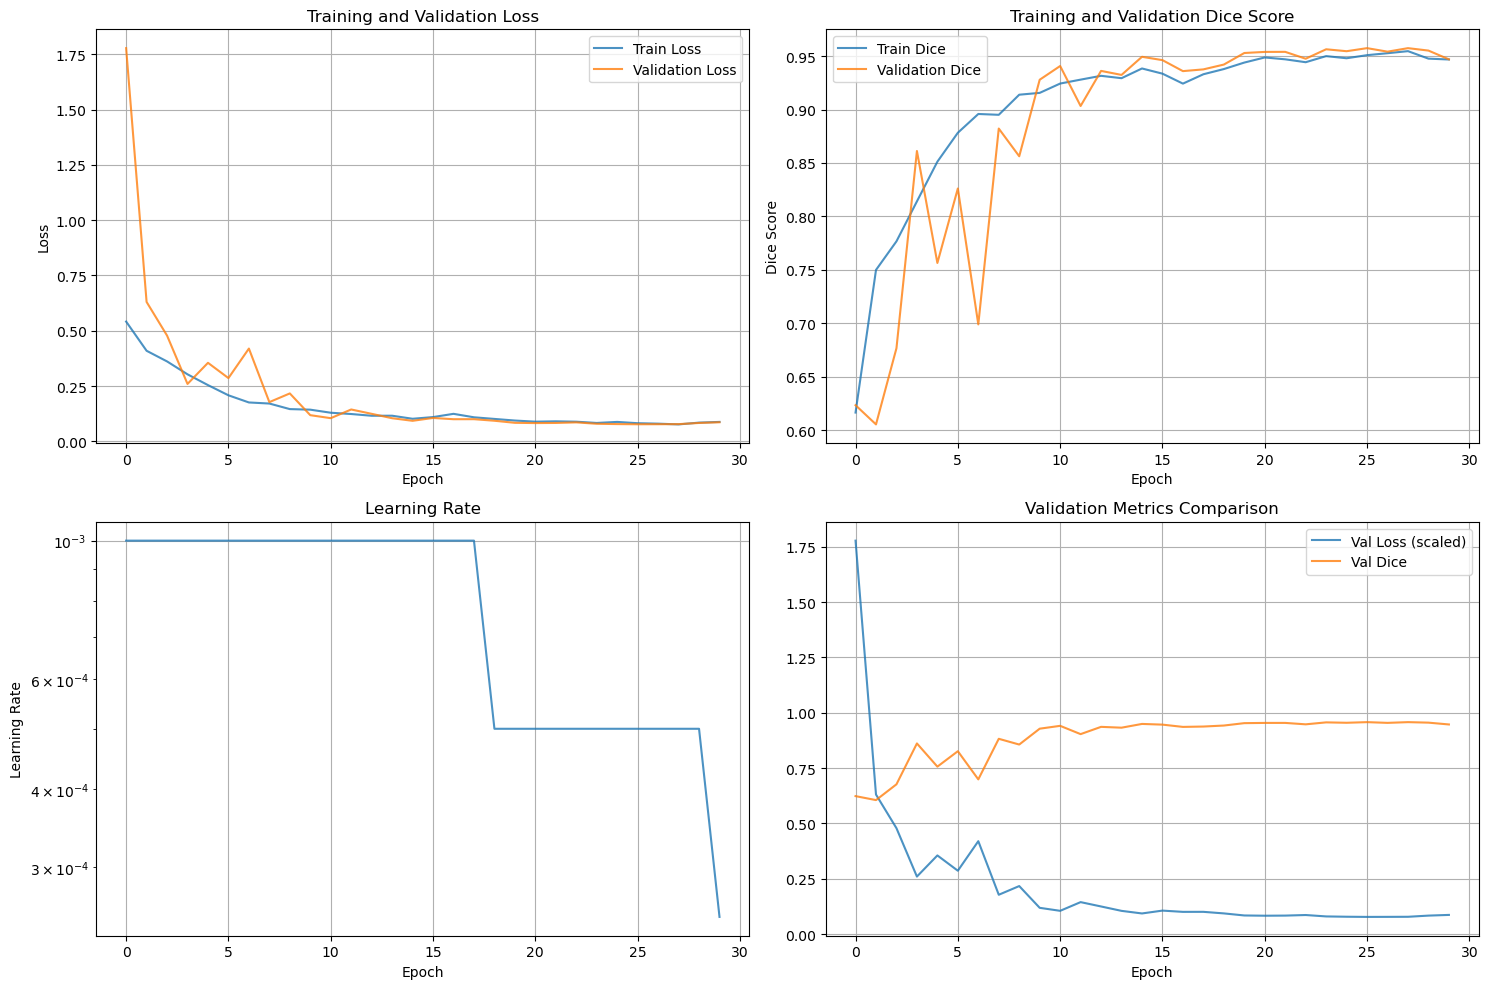

=== 训练结果总结 ===
最佳验证Dice: 0.9575
最终训练损失: 0.0881
最终验证损失: 0.0865
最终训练Dice: 0.9469
最终验证Dice: 0.9470
训练总轮数: 30


In [24]:
# Plot training curves
trainer.plot_training_curves(save_path='../DISSERTATION/outputs/unet_training_curves.png')

# Print final results
print(f"Best validation Dice: {max(history['val_dice']):.4f}")
print(f"Final training loss: {history['train_loss'][-1]:.4f}")
print(f"Final validation loss: {history['val_loss'][-1]:.4f}")
print(f"Final training Dice: {history['train_dice'][-1]:.4f}")
print(f"Final validation Dice: {history['val_dice'][-1]:.4f}")
print(f"Total training epochs: {len(history['train_loss'])}")


In [ ]:
## 7. Model Prediction Visualization

验证集预测可视化:


/var/folders/6n/2rqv_pbj5r5g_dc4brtwrg800000gn/T/ipykernel_23828/1690974741.py:56: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6n/2rqv_pbj5r5g_dc4brtwrg800000gn/T/ipykernel_23828/1690974741.py:56: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6n/2rqv_pbj5r5g_dc4brtwrg800000gn/T/ipykernel_23828/1690974741.py:56: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6n/2rqv_pbj5r5g_dc4brtwrg800000gn/T/ipykernel_23828/1690974741.py:56: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6n/2rqv_pbj5r5g_dc4brtwrg800000gn/T/ipykernel_23828/1690974741.py:56: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6n/2rqv

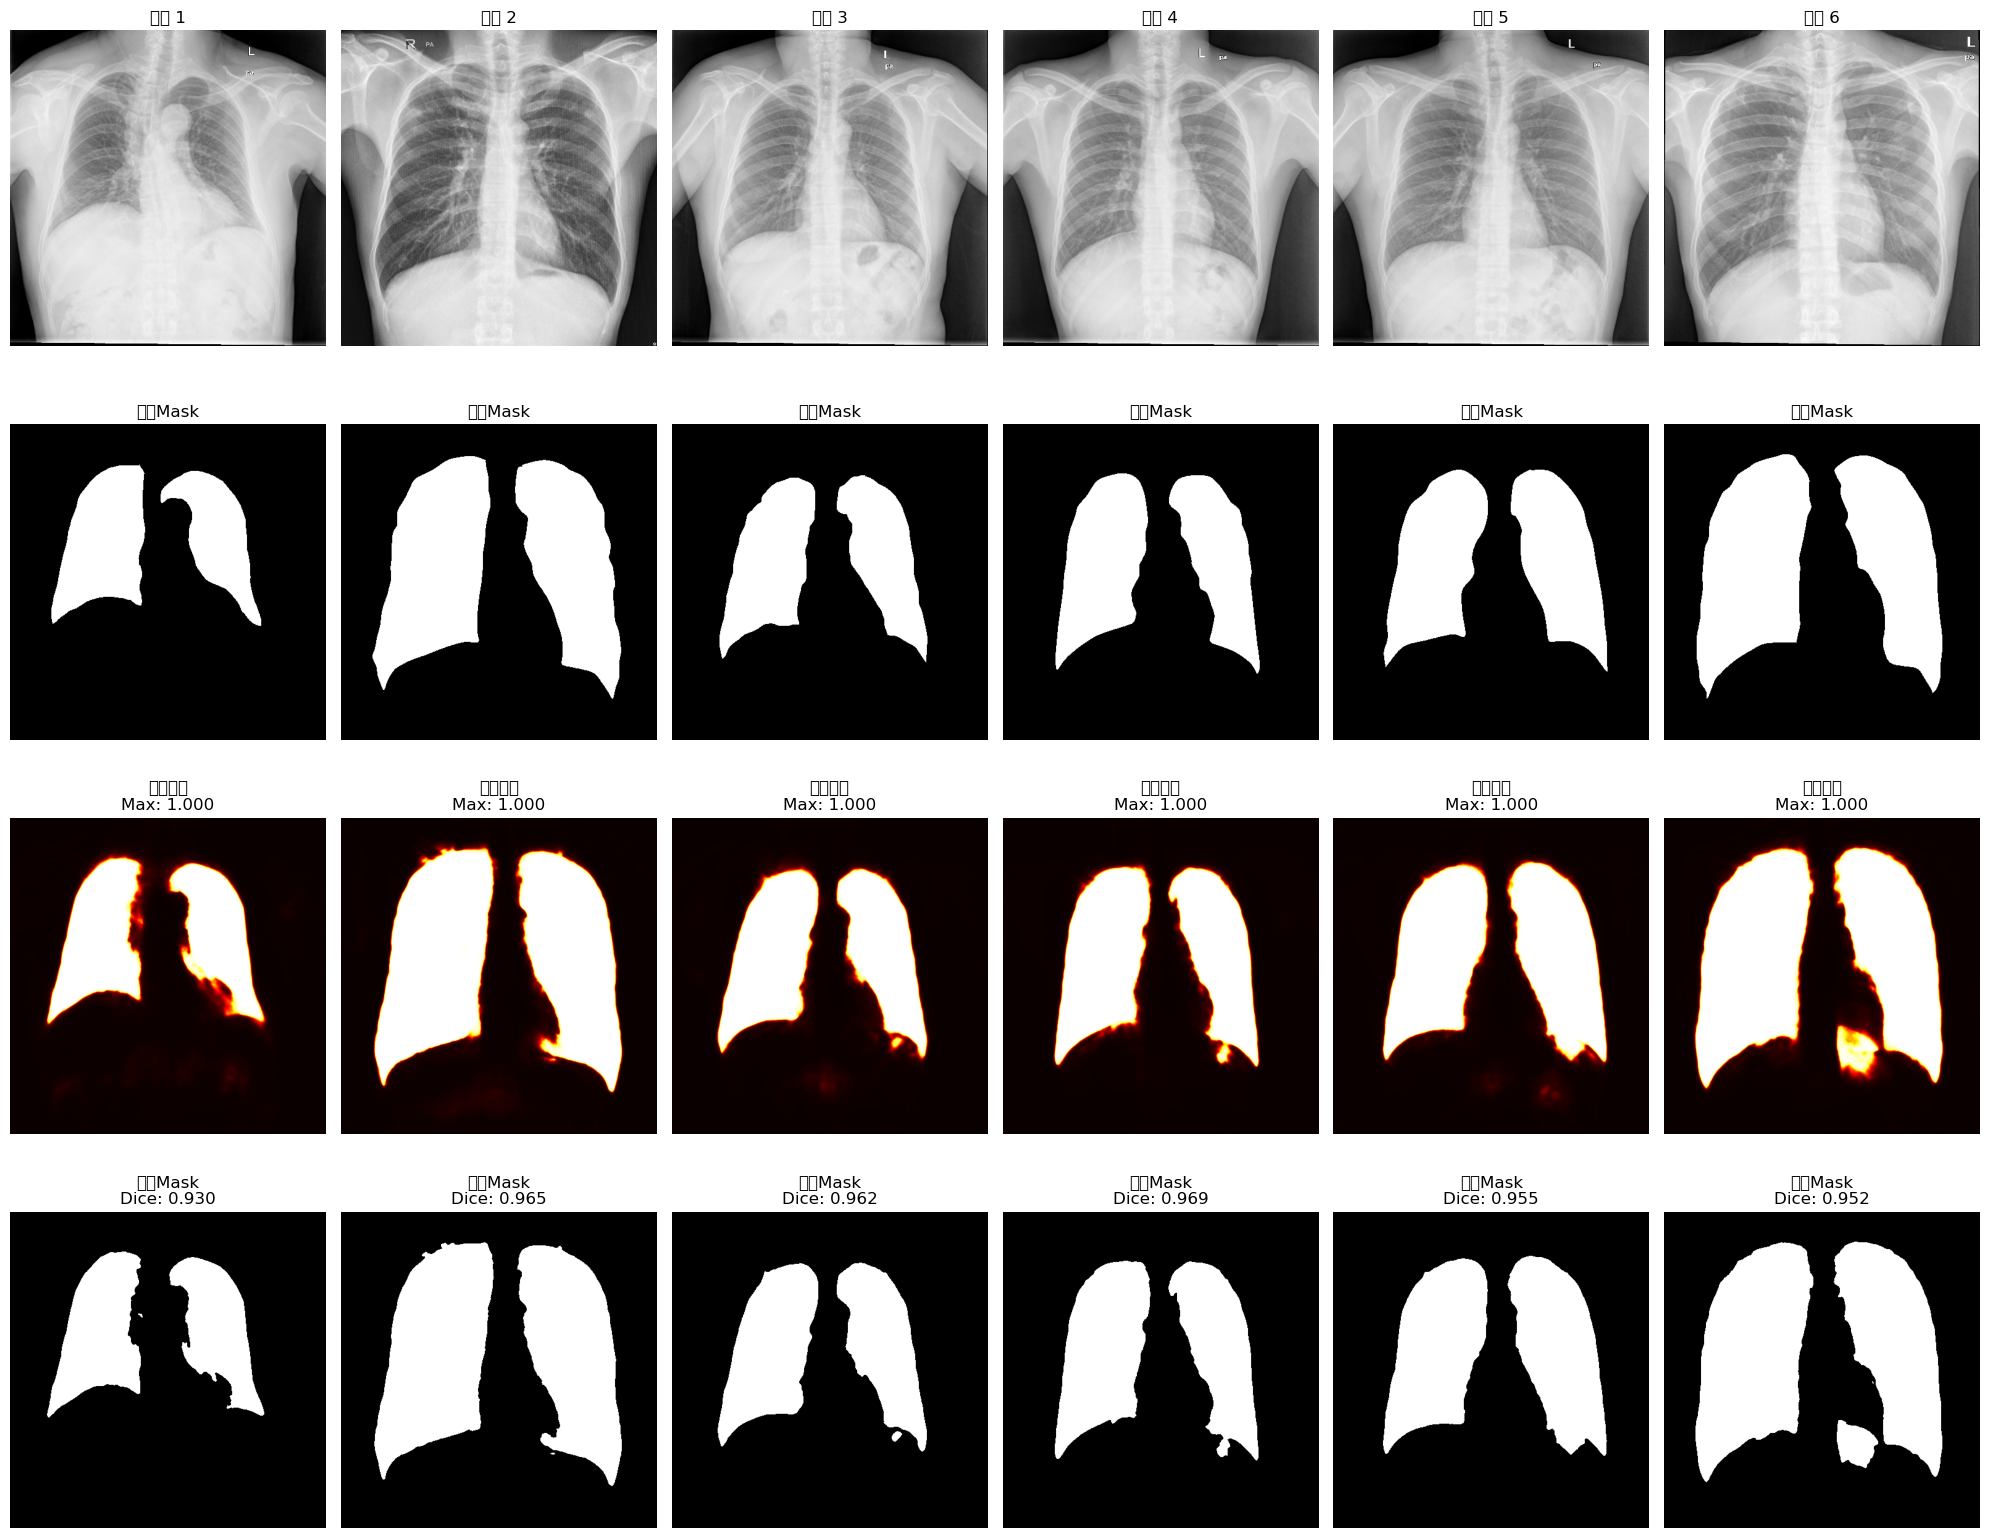

In [30]:
# Load the best model for inference
best_model_path = '../checkpoints/unet/best_model.pt'
if os.path.exists(best_model_path):
    print("Loading the best model...")
    checkpoint = torch.load(best_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded model epoch: {checkpoint['epoch']}")
    print(f"Loaded model Dice: {checkpoint['metrics']['dice']:.4f}")

# Visualize predictions on the validation set
def visualize_predictions(model, dataloader, num_samples=6):
    model.eval()
    
    # Randomly select samples
    sample_indices = np.random.choice(len(dataloader.dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(4, num_samples, figsize=(20, 16))
    
    with torch.no_grad():
        for i, idx in enumerate(sample_indices):
            sample = dataloader.dataset[idx]
            
            image = sample['image'].unsqueeze(0).to(device)
            mask = sample['mask'].squeeze().cpu().numpy()
            
            # Model prediction
            pred = model(image)
            pred_prob = torch.sigmoid(pred).squeeze().cpu().numpy()
            pred_binary = (pred_prob > 0.5).astype(np.float32)
            
            # Original image
            img_display = image.squeeze().cpu().numpy()
            axes[0, i].imshow(img_display, cmap='gray')
            axes[0, i].set_title(f'Original {i+1}')
            axes[0, i].axis('off')
            
            # Ground-truth mask
            axes[1, i].imshow(mask, cmap='gray')
            axes[1, i].set_title('Ground Truth Mask')
            axes[1, i].axis('off')
            
            # Predicted probability
            axes[2, i].imshow(pred_prob, cmap='hot')
            axes[2, i].set_title(f'Prediction Probability\nMax: {pred_prob.max():.3f}')
            axes[2, i].axis('off')
            
            # Binarized prediction
            axes[3, i].imshow(pred_binary, cmap='gray')
            
            # Compute Dice score
            from utils.metrics import dice_coefficient
            dice = dice_coefficient(pred, sample['mask'].unsqueeze(0))
            axes[3, i].set_title(f'Predicted Mask\nDice: {dice:.3f}')
            axes[3, i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Validation set prediction visualization:")
visualize_predictions(model, val_loader, num_samples=6)


## 8. Evaluation on the Test Set

In [28]:
# Evaluate the model on the test set
def evaluate_on_test_set(model, test_loader):
    model.eval()
    test_metrics = SegmentationMetrics()
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Testing'):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            
            outputs = model(images)
            test_metrics.update(outputs, masks)
    
    results = test_metrics.compute()
    return results

# Run evaluation on test set
test_results = evaluate_on_test_set(model, test_loader)

print("=== Test Set Results ===")
print(f"Dice Score: {test_results['dice']:.4f} ± {test_results['dice_std']:.4f}")
print(f"IoU Score: {test_results['iou']:.4f} ± {test_results['iou_std']:.4f}")
print(f"Precision: {test_results['precision']:.4f}")
print(f"Recall: {test_results['recall']:.4f}")
print(f"Accuracy: {test_results['accuracy']:.4f}")
print(f"F1 Score: {test_results['f1']:.4f}")


在测试集上评估...


测试:   0%|          | 0/14 [00:00<?, ?it/s]

=== 测试集结果 ===
Dice Score: 0.9467 ± 0.0232
IoU Score: 0.8997 ± 0.0409
Precision: 0.9255
Recall: 0.9710
Accuracy: 0.9726
F1 Score: 0.9467


## 9. Save Results

In [ ]:
# Save training history and test results
results_data = {
    'model_name': 'UNet',
    'config': config,
    'training_history': history,
    'test_results': test_results,
    'model_summary': model.get_model_summary()
}

# Ensure output directory exists
os.makedirs('../outputs/results', exist_ok=True)

# Save as JSON
with open('../outputs/results/unet_results.json', 'w') as f:
    json.dump(results_data, f, indent=2, default=str)

print("Results saved to outputs/results/unet_results.json")

# Save the final model to the specified path
final_model_path = '../checkpoints/unet_best.pt'
if os.path.exists('../checkpoints/best_model.pt'):
    import shutil
    shutil.copy('../checkpoints/best_model.pt', final_model_path)
    print(f"Best model saved to {final_model_path}")



In [ ]:
%cd ~/Documents/DISSERTATION